In [73]:
!pip install adjustText

  Using cached adjustText-0.8-py3-none-any.whl (9.1 kB)


In [74]:
# Dependencies
import matplotlib as mpl
import os
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  

import fastf1 as ff1
from fastf1.ergast import Ergast
ergast = Ergast()


In [2]:
# Create a directory for cache if it doesn't exist
if not os.path.exists('../cache'):
    os.makedirs('../cache')

In [3]:
# Enable fastf1 cache
ff1.Cache.enable_cache('../cache')

In [4]:
# Pull the latest session
# TODO: Find a better way to get current drivers
session = ff1.get_session(2023, 'Canada', 'R')
session.load()
data = session.results

current_drivers = data[['DriverId', 'Abbreviation']]

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']


In [5]:
data

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,NED,1.0,1,1.0,NaT,NaT,NaT,0 days 01:33:58.348000,Finished,25.0
14,14,F ALONSO,ALO,alonso,Aston Martin,358C75,aston_martin,Fernando,Alonso,Fernando Alonso,...,ESP,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:09.570000,Finished,18.0
44,44,L HAMILTON,HAM,hamilton,Mercedes,6CD3BF,mercedes,Lewis,Hamilton,Lewis Hamilton,...,GBR,3.0,3,3.0,NaT,NaT,NaT,0 days 00:00:04.598000,Finished,15.0
16,16,C LECLERC,LEC,leclerc,Ferrari,F91536,ferrari,Charles,Leclerc,Charles Leclerc,...,MON,4.0,4,10.0,NaT,NaT,NaT,0 days 00:00:18.648000,Finished,12.0
55,55,C SAINZ,SAI,sainz,Ferrari,F91536,ferrari,Carlos,Sainz,Carlos Sainz,...,ESP,5.0,5,11.0,NaT,NaT,NaT,0 days 00:00:21.540000,Finished,10.0
11,11,S PEREZ,PER,perez,Red Bull Racing,3671C6,red_bull,Sergio,Perez,Sergio Perez,...,MEX,6.0,6,12.0,NaT,NaT,NaT,0 days 00:00:51.028000,Finished,9.0
23,23,A ALBON,ALB,albon,Williams,37BEDD,williams,Alexander,Albon,Alexander Albon,...,THA,7.0,7,9.0,NaT,NaT,NaT,0 days 00:01:00.813000,Finished,6.0
31,31,E OCON,OCO,ocon,Alpine,2293D1,alpine,Esteban,Ocon,Esteban Ocon,...,FRA,8.0,8,6.0,NaT,NaT,NaT,0 days 00:01:01.692000,Finished,4.0
18,18,L STROLL,STR,stroll,Aston Martin,358C75,aston_martin,Lance,Stroll,Lance Stroll,...,CAN,9.0,9,16.0,NaT,NaT,NaT,0 days 00:01:04.402000,Finished,2.0
77,77,V BOTTAS,BOT,bottas,Alfa Romeo,C92D4B,alfa,Valtteri,Bottas,Valtteri Bottas,...,FIN,10.0,10,14.0,NaT,NaT,NaT,0 days 00:01:04.432000,Finished,1.0


In [6]:
def get_quali_results(year, circuit):
    '''
    Get the qualifying results for a given year and circuit.
    '''
    session = ff1.get_session(year, circuit, 'Q')
    session.load(telemetry=False)
    
    data = session.results
    data['Year'] = year
    data['Circuit'] = circuit

    data = data[['DriverId', 'Year', 'Circuit', 'Position']]

    return data

In [7]:
def get_rainfall_quali_results(year, circuit):
    '''
    Returns the qualifying results for a given year and circuit if it rained 
    for > 50% of the qualifying session. Otherwise, returns None.
    '''
    session = ff1.get_session(year, circuit, 'Q')
    session.load(telemetry=False)
    weather = session.weather_data

    if weather['Rainfall'].mean() > 0.5:
        print(f'Rain in qualifying for {year} {circuit}.')
        data = session.results
        data['Year'] = year
        data['Circuit'] = session.event.EventName

        data = data[['DriverId', 'Year', 'Circuit', 'Position']]

        return data
    
    else:
        print(f'No rain in qualifying for {year} {circuit}.')
        return None

In [9]:
# Loop through all of 2018 to get the qualifying results
quali = pd.DataFrame()

for season in range(2018, 2024):
    try:
        for circuit in ergast.get_circuits(season=season)['circuitName']:
            quali = quali.append(get_quali_results(season, circuit))
    except:
        pass

core           INFO 	Loading data for Mexican Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '33', '44', '5', '77', '7', '27', '55', '16', '9', '31', '14', '11', '28', '10', '8', '2', '20', '18', '35']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cache

In [10]:
# Loop through all of 2018 to get where it rained, concat into one dataframe
rainfall_quali_results = pd.DataFrame()

for season in range(2018, 2024):
    try:
        for circuit in ergast.get_circuits(season=season)['circuitName']:
                rainfall_quali_results = pd.concat([rainfall_quali_results, get_rainfall_quali_results(season, circuit)])
    except:
        pass

core           INFO 	Loading data for Mexican Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '33', '44', '5', '77', '7', '27', '55', '16', '9', '31', '14', '11', '28', '10', '8', '2', '20', '18', '35']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cache

No rain in qualifying for 2018 Albert Park Grand Prix Circuit.
Rain in qualifying for 2018 Circuit of the Americas.


logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '7', '77', '44', '3', '10', '20', '27', '31', '55', '28', '11', '14', '2', '33', '8', '9', '35', '16', '18']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 77: Ignoring late data for a previously processed lap.The data may contain errors (previous: 10; current 11)
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weat

No rain in qualifying for 2018 Bahrain International Circuit.
No rain in qualifying for 2018 Baku City Circuit.


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '7', '33', '3', '20', '14', '55', '8', '2', '10', '31', '16', '11', '27', '9', '35', '18', '28']
core           INFO 	Loading data for German Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing

Rain in qualifying for 2018 Circuit de Barcelona-Catalunya.
No rain in qualifying for 2018 Hockenheimring.


core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '7', '5', '55', '10', '33', '28', '20', '8', '14', '3', '27', '9', '18', '2', '16', '31', '11', '35']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached da

Rain in qualifying for 2018 Hungaroring.
No rain in qualifying for 2018 Autódromo José Carlos Pace.
No rain in qualifying for 2018 Marina Bay Street Circuit.


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '14', '55', '11', '10', '27', '2', '35', '16', '8', '28', '9', '18', '20', '33']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached d

No rain in qualifying for 2018 Circuit de Monaco.
No rain in qualifying for 2018 Autodromo Nazionale di Monza.
No rain in qualifying for 2018 Red Bull Ring.


core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['7', '5', '44', '77', '33', '8', '55', '31', '10', '18', '20', '35', '14', '27', '3', '11', '16', '28', '9', '2']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cac

No rain in qualifying for 2018 Circuit Paul Ricard.
No rain in qualifying for 2018 Autódromo Hermanos Rodríguez.


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 77: Ignoring late data for a previously processed lap.The data may contain errors (previous: 8; current 9)
_api        WARNING 	Driver 77: Ignoring late data for a previously processed lap.The data may contain errors (previous: 11; current 12)
_api        WARNING 	Driver 11: Ignoring late data for a previously processed lap.The data may contain errors (previous: 7; current 8)
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '7', '77', '44', '33', '3', '27', '11', '55', '8', '20', '31', '14', '

No rain in qualifying for 2018 Shanghai International Circuit.


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '7', '77', '33', '3', '20', '8', '16', '31', '27', '11', '14', '10', '9', '55', '2', '35', '18', '28']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2018 Silverstone Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '7', '20', '31', '16', '11', '8', '9', '33', '3', '10', '55', '27', '28', '14', '35', '2', '18']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2018 Sochi Autodrom.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '31', '11', '8', '7', '33', '3', '20', '77', '10', '28', '16', '9', '27', '55', '14', '35', '18', '2']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2018 Circuit de Spa-Francorchamps.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '7', '8', '28', '10', '31', '5', '11', '16', '20', '55', '18', '3', '27', '35', '14', '2', '9']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '3', '7', '55', '16', '20', '8'

No rain in qualifying for 2018 Suzuka Circuit.
Rain in qualifying for 2018 Circuit Gilles Villeneuve.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '7', '3', '33', '8', '16', '31', '27', '55', '9', '20', '11', '14', '28', '10', '2', '35', '18']
core           INFO 	Loading data for Brazilian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2018 Yas Marina Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '5', '44', '16', '77', '23', '10', '8', '7', '20', '4', '3', '99', '27', '11', '26', '18', '63', '88', '55']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Albert Park Grand Prix Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '4', '55', '5', '3', '10', '99', '23', '7', '27', '11', '20', '26', '8', '18', '63', '88']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Circuit of the Americas.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '5', '44', '77', '33', '20', '55', '8', '7', '4', '3', '23', '10', '11', '26', '99', '27', '18', '63', '88']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Bahrain International Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '33', '77', '20', '4', '7', '99', '10', '5', '8', '27', '23', '3', '55', '11', '18', '26', '63', '88']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Baku City Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '10', '8', '20', '26', '3', '4', '23', '55', '7', '11', '27', '18', '99', '63', '88']
core           INFO 	Loading data for German Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Circuit de Barcelona-Catalunya.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '10', '7', '8', '55', '11', '27', '16', '99', '20', '3', '26', '18', '4', '23', '63', '88', '5']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Hockenheimring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '16', '5', '10', '4', '55', '8', '7', '27', '23', '26', '99', '20', '63', '11', '3', '18', '88']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Hungaroring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '10', '20', '3', '26', '55', '23', '27', '4', '8', '7', '99', '16', '11', '18', '63', '88']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Autódromo José Carlos Pace.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '10', '20', '3', '26', '55', '23', '27', '4', '8', '7', '99', '16', '11', '18', '63', '88']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Marina Bay Street Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '10', '20', '3', '26', '55', '23', '27', '4', '8', '7', '99', '16', '11', '18', '63', '88']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Circuit de Monaco.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '16', '8', '20', '4', '7', '11', '27', '3', '23', '99', '26', '18', '10', '55', '63', '88']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Autodromo Nazionale di Monza.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '16', '33', '10', '5', '3', '4', '23', '27', '99', '7', '55', '8', '11', '20', '26', '18', '63', '88']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Red Bull Ring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '77', '5', '3', '27', '55', '23', '18', '7', '99', '20', '26', '4', '10', '8', '11', '63', '88', '33']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Circuit Paul Ricard.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '33', '77', '20', '4', '7', '99', '10', '5', '8', '27', '23', '3', '55', '11', '18', '26', '63', '88']
core           INFO 	Loading data for Chinese Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 77: Ignoring late data for a previously processed lap.The data may contain errors (previous: 13; current 14)
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data f

No rain in qualifying for 2019 Autódromo Hermanos Rodríguez.
No rain in qualifying for 2019 Shanghai International Circuit.


req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '16', '33', '10', '5', '3', '4', '23', '27', '99', '7', '55', '8', '11', '20', '26', '18', '63', '88']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            I

No rain in qualifying for 2019 Silverstone Circuit.
No rain in qualifying for 2019 Sochi Autodrom.


core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '5', '44', '77', '33', '3', '27', '7', '11', '20', '8', '4', '18', '23', '99', '10', '55', '26', '63', '88']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using

No rain in qualifying for 2019 Circuit de Spa-Francorchamps.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '16', '77', '44', '33', '23', '55', '4', '10', '8', '99', '18', '7', '26', '27', '3', '11', '63', '20', '88']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Suzuka Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '4', '55', '5', '3', '10', '99', '23', '7', '27', '11', '20', '26', '8', '18', '63', '88']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Circuit Gilles Villeneuve.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '33', '77', '20', '4', '7', '99', '10', '5', '8', '27', '23', '3', '55', '11', '18', '26', '63', '88']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2019 Yas Marina Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '23', '11', '3', '31', '10', '4', '26', '5', '16', '18', '63', '55', '99', '7', '20', '8', '6']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Bahrain International Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '11', '18', '23', '55', '4', '16', '10', '5', '26', '3', '7', '31', '20', '8', '63', '6', '99']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Circuit de Barcelona-Catalunya.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '18', '11', '5', '16', '33', '4', '55', '10', '3', '63', '23', '31', '6', '20', '26', '8', '99', '7']
core           INFO 	Loading data for Tuscan Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Hungaroring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '23', '16', '11', '18', '3', '55', '31', '4', '26', '7', '5', '8', '10', '99', '63', '6', '20']
core           INFO 	Loading data for Turkish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Autodromo Enzo e Dino Ferrari.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['18', '33', '11', '23', '3', '44', '31', '7', '77', '99', '4', '5', '55', '16', '10', '20', '26', '63', '8', '6']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Istanbul Park.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '11', '18', '23', '55', '4', '16', '10', '5', '26', '3', '7', '31', '20', '8', '63', '6', '99']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Autodromo Nazionale di Monza.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '11', '18', '23', '55', '4', '16', '10', '5', '26', '3', '7', '31', '20', '8', '63', '6', '99']
core           INFO 	Loading data for Eifel Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Autodromo Internazionale del Mugello.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '31', '4', '11', '55', '5', '10', '26', '99', '20', '8', '63', '6', '7', '27']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Nürburgring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '4', '23', '11', '16', '55', '18', '3', '5', '10', '26', '31', '8', '20', '63', '99', '7', '6']
core           INFO 	Loading data for Eifel Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Autódromo Internacional do Algarve.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '31', '4', '11', '55', '5', '10', '26', '99', '20', '8', '63', '6', '7', '27']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Red Bull Ring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '4', '18', '55', '3', '31', '5', '10', '23', '27', '26', '63', '20', '99', '7', '8', '6']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Silverstone Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '3', '55', '31', '4', '10', '23', '16', '26', '18', '63', '5', '8', '99', '20', '6', '7']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Sochi Autodrom.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '23', '31', '55', '11', '18', '4', '26', '10', '16', '5', '63', '7', '8', '99', '6', '20']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Circuit de Spa-Francorchamps.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '4', '23', '11', '16', '55', '18', '3', '5', '10', '26', '31', '8', '20', '63', '99', '7', '6']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2020 Yas Marina Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '11', '55', '10', '16', '4', '14', '3', '31', '5', '99', '63', '47', '6', '7', '9', '18', '22']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Circuit of the Americas.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '10', '3', '4', '55', '14', '18', '11', '99', '22', '7', '63', '31', '6', '5', '47', '9']
core           INFO 	Loading data for Styrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Bahrain International Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '4', '11', '10', '16', '22', '14', '18', '63', '55', '3', '5', '99', '6', '31', '7', '47', '9']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Baku City Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '31', '55', '3', '11', '4', '14', '18', '10', '5', '99', '63', '22', '7', '47', '6', '9']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Driver 77: Ignoring late data for a previously processed lap.The data may contain errors (previous: 17; current 18)


No rain in qualifying for 2021 Circuit de Barcelona-Catalunya.


_api        WARNING 	Driver 10: Ignoring late data for a previously processed lap.The data may contain errors (previous: 7; current 8)
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '11', '10', '4', '16', '31', '14', '5', '3', '18', '7', '99', '55', '22', '63', '6', '9', '47']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Hungaroring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '11', '10', '4', '22', '31', '99', '3', '7', '14', '63', '55', '6', '5', '18', '47', '9']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...


No rain in qualifying for 2021 Autodromo Enzo e Dino Ferrari.


_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '33', '77', '55', '4', '10', '44', '5', '11', '99', '31', '3', '18', '7', '63', '22', '14', '6', '9', '47']
core           INFO 	Loading data for Turkish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Autódromo José Carlos Pace.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '10', '14', '11', '4', '18', '22', '5', '31', '63', '47', '55', '3', '6', '99', '7', '9']
core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Istanbul Park.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '11', '10', '55', '3', '16', '22', '4', '5', '7', '63', '99', '31', '14', '6', '47', '9', '18']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Jeddah Corniche Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '4', '3', '63', '55', '5', '14', '10', '31', '99', '18', '22', '7', '6', '47', '9']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...


No rain in qualifying for 2021 Losail International Circuit.


_api           INFO 	Parsing timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '33', '77', '55', '4', '10', '44', '5', '11', '99', '31', '3', '18', '7', '63', '22', '14', '6', '9', '47']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Circuit de Monaco.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '77', '16', '55', '3', '4', '10', '22', '31', '5', '99', '14', '63', '18', '6', '7', '47', '9']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Autodromo Nazionale di Monza.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '4', '3', '10', '55', '16', '11', '99', '5', '18', '14', '31', '63', '6', '22', '47', '88', '9']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Autódromo Internacional do Algarve.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '4', '3', '63', '55', '5', '14', '10', '31', '99', '18', '22', '7', '6', '47', '9']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Red Bull Ring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '4', '3', '10', '55', '16', '11', '99', '5', '18', '14', '31', '63', '6', '22', '47', '88', '9']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Circuit Paul Ricard.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '31', '55', '3', '11', '4', '14', '18', '10', '5', '99', '63', '22', '7', '47', '6', '9']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Autódromo Hermanos Rodríguez.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '4', '3', '63', '55', '5', '14', '10', '31', '99', '18', '22', '7', '6', '47', '9']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Silverstone Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '63', '44', '3', '14', '77', '18', '11', '31', '5', '10', '22', '6', '16', '7', '47', '99', '9', '33']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Sochi Autodrom.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '11', '77', '31', '4', '16', '6', '55', '14', '18', '99', '22', '47', '7', '9']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Circuit de Spa-Francorchamps.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '4', '11', '44', '77', '10', '22', '5', '63', '18', '55', '16', '3', '14', '99', '7', '31', '6', '47', '9']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Yas Marina Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '55', '99', '31', '14', '3', '63', '18', '4', '6', '22', '11', '5', '88', '47', '9']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2021 Circuit Park Zandvoort.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '63', '4', '3', '10', '14', '31', '77', '45', '24', '22', '6', '5', '18', '20', '47']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Albert Park Grand Prix Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '11', '16', '31', '14', '44', '63', '23', '4', '3', '10', '24', '18', '47', '5', '6', '20', '22', '77']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Circuit of the Americas.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '77', '20', '14', '63', '10', '31', '47', '4', '23', '24', '22', '27', '3', '18', '6']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Bahrain International Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '63', '31', '20', '47', '14', '44', '10', '23', '77', '11', '22', '4', '3', '18', '24', '6', '5']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Baku City Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '63', '11', '44', '77', '20', '3', '47', '4', '31', '22', '10', '24', '5', '14', '18', '23', '6']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Circuit de Barcelona-Catalunya.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '55', '16', '4', '31', '14', '44', '77', '3', '1', '11', '24', '20', '18', '47', '22', '23', '5', '10', '6']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Hungaroring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '44', '4', '63', '14', '22', '55', '20', '3', '31', '77', '5', '23', '10', '18', '24', '47', '6']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Autodromo Enzo e Dino Ferrari.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14', '77', '23', '5', '10', '24', '22', '20', '3', '31', '47', '6']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Autódromo José Carlos Pace.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '1', '31', '63', '14', '77', '10', '20', '4', '3', '24', '47', '18', '44', '23', '27', '6', '22']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Jeddah Corniche Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '44', '55', '14', '4', '10', '1', '20', '22', '63', '18', '47', '5', '24', '77', '3', '31', '23', '6']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Marina Bay Street Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '4', '44', '63', '3', '31', '55', '14', '10', '77', '22', '24', '47', '23', '20', '5', '6', '18']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Miami International Autodrome.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '11', '1', '4', '63', '14', '44', '5', '31', '22', '77', '20', '3', '47', '23', '10', '18', '6', '24']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Circuit de Monaco.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '11', '4', '44', '63', '3', '31', '55', '14', '10', '77', '22', '24', '47', '23', '20', '5', '6', '18']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Autodromo Nazionale di Monza.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '11', '44', '4', '14', '63', '24', '6', '10', '77', '22', '3', '31', '23', '20', '5', '47', '18']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Rain in qualifying for 2022 Red Bull Ring.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '55', '11', '44', '63', '4', '3', '10', '14', '31', '77', '45', '24', '22', '6', '5', '18', '20', '47']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Circuit Paul Ricard.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '1', '31', '63', '14', '77', '10', '20', '4', '3', '24', '47', '18', '44', '23', '27', '6', '22']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Autódromo Hermanos Rodríguez.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '11', '44', '4', '14', '63', '24', '6', '10', '77', '22', '3', '31', '23', '20', '5', '47', '18']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Rain in qualifying for 2022 Silverstone Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '11', '16', '31', '14', '44', '63', '23', '4', '3', '10', '24', '18', '47', '5', '6', '20', '22', '77']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Circuit de Spa-Francorchamps.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '31', '44', '14', '63', '5', '4', '3', '77', '22', '24', '47', '23', '10', '20', '18', '6']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Suzuka Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14', '77', '23', '5', '10', '24', '22', '20', '3', '31', '47', '6']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Circuit Gilles Villeneuve.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '44', '55', '14', '4', '10', '1', '20', '22', '63', '18', '47', '5', '24', '77', '3', '31', '23', '6']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.0.6]
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


No rain in qualifying for 2022 Yas Marina Circuit.


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '44', '11', '63', '4', '47', '22', '18', '10', '31', '14', '24', '23', '77', '3', '20', '5', '6']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.0.6]
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...


No rain in qualifying for 2022 Circuit Park Zandvoort.


core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
logger      WARNING 	Failed to load results data!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
logger      WARNING 	Failed to load timing data!
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
logger      WARNING 	Failed to load weather data!
req            INFO 	No cached data found for race_

In [11]:
quali = quali[['DriverId', 'Position']]\
        .groupby('DriverId').mean()\
        .reset_index()\
        .rename(columns={'Position': 'AvgQualiPos'})

In [12]:
# group the same way as quali, but add a N column for count of number of times raced in the rain
rainfall_quali_results = rainfall_quali_results[['DriverId', 'Position']]\
        .groupby('DriverId').agg(['mean', 'count'])\
        .reset_index()

rainfall_quali_results.columns = ['DriverId', 'AvgQualiPosRain', 'N']

In [13]:
rainfall_quali_results

,DriverId,AvgQualiPosRain,N
0,albon,16.000000,2
1,alonso,10.833333,6
2,bottas,5.333333,6
3,brendon_hartley,15.500000,4
4,ericsson,15.250000,4
5,gasly,11.333333,6
6,grosjean,10.000000,4
7,hamilton,2.333333,6
8,hulkenberg,13.250000,4
9,kevin_magnussen,11.333333,6


In [14]:
df = quali.merge(rainfall_quali_results, on='DriverId', how='left')

In [15]:
df

,DriverId,AvgQualiPos,AvgQualiPosRain,N
0,albon,11.425926,16.000000,2.0
1,alonso,10.750000,10.833333,6.0
2,bottas,5.000000,5.333333,6.0
3,brendon_hartley,15.714286,15.500000,4.0
4,de_vries,13.000000,NaN,NaN
5,ericsson,15.904762,15.250000,4.0
6,gasly,10.262626,11.333333,6.0
7,giovinazzi,13.818182,NaN,NaN
8,grosjean,11.964286,10.000000,4.0
9,hamilton,3.111111,2.333333,6.0


In [16]:
# Merge with the current drivers
df = df.merge(current_drivers, on='DriverId', how='inner')

df

,DriverId,AvgQualiPos,AvgQualiPosRain,N,Abbreviation
0,albon,11.425926,16.000000,2.0,ALB
1,alonso,10.750000,10.833333,6.0,ALO
2,bottas,5.000000,5.333333,6.0,BOT
3,de_vries,13.000000,NaN,NaN,DEV
4,gasly,10.262626,11.333333,6.0,GAS
5,hamilton,3.111111,2.333333,6.0,HAM
6,hulkenberg,12.020833,13.250000,4.0,HUL
7,kevin_magnussen,12.487179,11.333333,6.0,MAG
8,leclerc,6.525253,8.833333,6.0,LEC
9,max_verstappen,4.262626,4.000000,6.0,VER


In [57]:
# change N to an int, drop nan rows
df['N'] = df['N'].fillna(0).astype(int)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


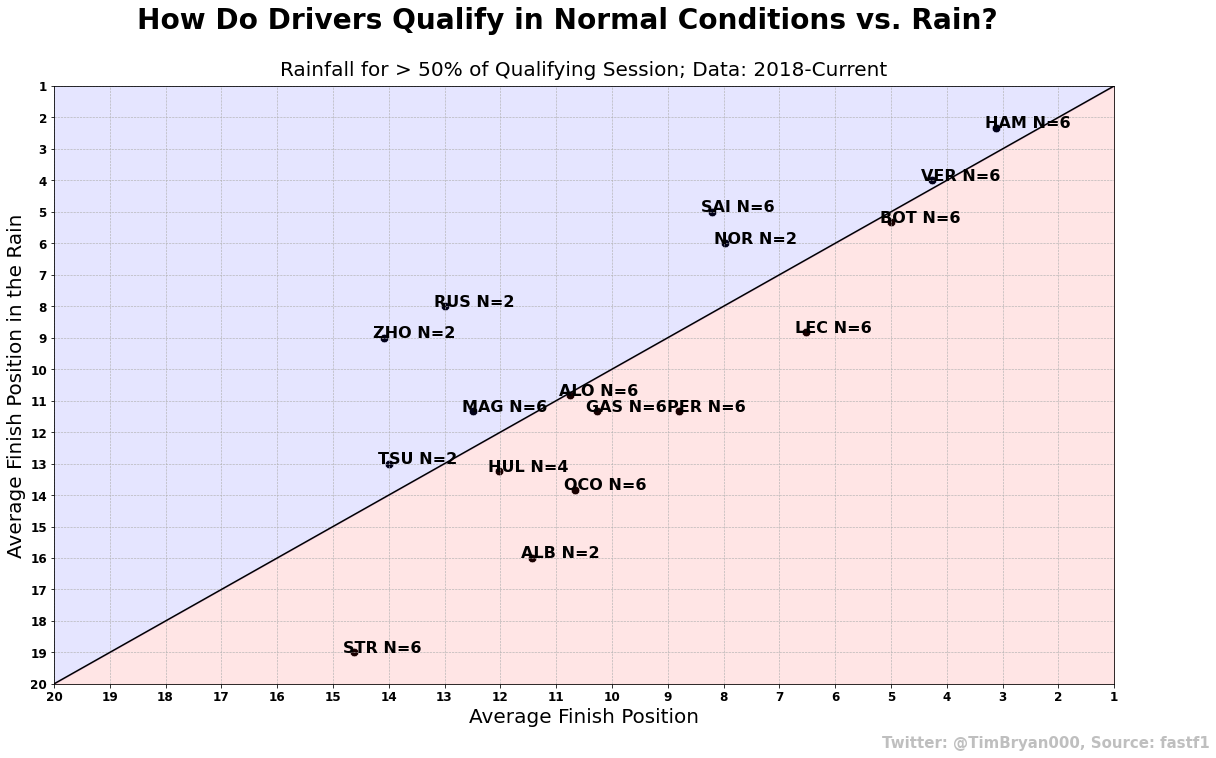

In [80]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define custom font
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 12}
mpl.rc('font', **font)

# Create a scatter plot
plt.figure(figsize=(19, 11))

# Add title and labels
plt.suptitle('How Do Drivers Qualify in Normal Conditions vs. Rain?',
             fontsize=28, fontweight='bold')
plt.title('Rainfall for > 50% of Qualifying Session; Data: 2018-Current',
          fontsize=20, loc='center', pad=10)

# Create a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.6)

# Scatterplot
sns.scatterplot(x='AvgQualiPos', y='AvgQualiPosRain',
                data=df, color="black", s=75)

# Draw a line from (20,20) to (1,1)
x = np.array([20, 1])
plt.plot(x, x, color='black')

# Annotating points with driver abbreviation and N = N
for line in range(0, df.shape[0]):
    plt.text(df['AvgQualiPos'][line]+0.2, df['AvgQualiPosRain'][line],  # adding small shift to prevent overlapping
             df['Abbreviation'][line] + ' N=' + str(df['N'][line]),
             horizontalalignment='left',
             size=16, color='black')  # Changed size to 'medium'
    

# invert axes
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Set the limits of the axes before inverting
plt.xlim([20, 1])
plt.ylim([20, 1])

# Set the ticks to whole numbers
plt.xticks(np.arange(20, 0, -1))
plt.yticks(np.arange(20, 0, -1))

plt.ylabel('Average Finish Position in the Rain',
           fontsize=20)  # Increased font size
plt.xlabel('Average Finish Position', fontsize=20)  # Increased font size

# Add text "Better in the Rain" and "Worse in the Rain"
# plt.text(5, 16, "Worse in the Rain", horizontalalignment='left',
#          size=14, color='blue')
# plt.text(16, 5, "Better in the Rain", horizontalalignment='left',
#          size=14, color='red')

# Color the triangle starting at (20,20) to (20,1) to (1,1)
plt.fill_between(x, x, 20, color='red', alpha=0.1)
plt.fill_between(x, x, 1, color='blue', alpha=0.1)

# Add a watermark
plt.text(0.85, 0.05, 'Twitter: @TimBryan000, Source: fastf1', fontsize=15, color='gray',
         ha='center', va='center', alpha=0.5, transform=plt.gcf().transFigure)

# Save the plot as a high-quality image
plt.savefig('rain_quali.png', dpi=300)

# Show the plot
plt.show()
